In [1]:
import keras
from keras.models import load_model, Model
from keras.layers import Input, Dense, Flatten, Conv1D,Conv2D, LSTM, Dropout
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel ")
options = Option(
    inputModel = 'KERAS_conv2d_model_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_conv2d.yml',
    jsonModel = 'KERAS_conv2d_model.json',
    #outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
#print(options.inputFile)
yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig


Using TensorFlow backend.


Loading configuration from train_config_conv2d.yml


{'Inputs': ['j1_etarot', 'j1_phirot', 'j1_ptrel', 'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'conv2d_model',
 'KerasModelRetrain': 'conv2d_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'NormalizeInputs': 0,
 'InputType': 'Conv2D',
 'BinsX': 40,
 'MinX': -0.8,
 'MaxX': 0.8,
 'BinsY': 40,
 'MinY': -1.0,
 'MaxY': 1.0,
 'MaxParticles': 100}

In [2]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df

,j_q,j1_ptrel,j_z,j_index,j_w,j1_phirot,j1_etarot,j_g,j_t
0,0,0.386118,0,101333,0,0.000000,0.000000,1,0
1,0,0.107734,0,101333,0,0.007236,-0.009859,1,0
2,0,0.094731,0,101333,0,-0.002759,0.004508,1,0
3,0,0.042086,0,101333,0,-0.014909,0.028567,1,0
4,0,0.039412,0,101333,0,-0.003745,-0.018020,1,0
...,...,...,...,...,...,...,...,...,...
5131608,0,0.000350,1,300123134,0,-0.315306,-0.300495,0,0
5131609,0,0.000258,1,300123134,0,-0.349366,0.258936,0,0
5131610,0,0.000219,1,300123134,0,-0.270430,0.269149,0,0
5131611,0,0.000116,1,300123134,0,-0.341398,-0.213081,0,0


In [3]:
MaxParticles = 100
BinsX = 40
MinX = -0.8
MaxX =  0.8
BinsY = 40
MinY = -1.0
MaxY = 1.0

# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

# get features
features_2dval = np.zeros((len(labels_df), BinsX, BinsY, 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(MinX, MaxX, BinsX + 1)
    ybins = np.linspace(MinY, MaxY, BinsY + 1)

    x = features_df_i[features[0]]
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins, ybins))

    for ix in range(0, BinsX):
        for iy in range(0, BinsY):
            features_2dval[i, ix, iy, 0] = hist[ix, iy]
features_val = features_2dval

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,
                                                                random_state=42)

# CNN2D model

In [ ]:
l1Reg = 0.0001

model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(11,11), strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg),input_shape=(40,40, 1)))
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv2D(filters=2, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

In [5]:
l1Reg = 0.0001

Inputs = Input(shape = (40,40,1))

x = Conv2D(filters=8, kernel_size=(11,11), strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(Inputs)

x = Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(x)

x = Conv2D(filters=2, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(x)

x = Flatten()(x)

x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg))(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)

model = Model(inputs=Inputs, outputs=predictions)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
conv2_relu_1 (Conv2D)        (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu_2 (Conv2D)        (None, 20, 20, 4)         292       
_________________________________________________________________
conv2_relu_3 (Conv2D)        (None, 10, 10, 2)         74        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                6432      
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 165   

In [6]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
58/58 [==============================] - 2s 38ms/step - loss: 1.6342 - accuracy: 0.2806 - val_loss: 1.5785 - val_accuracy: 0.3748
Epoch 2/100
58/58 [==============================] - 2s 29ms/step - loss: 1.4401 - accuracy: 0.4344 - val_loss: 1.3038 - val_accuracy: 0.4705
Epoch 3/100
58/58 [==============================] - 2s 30ms/step - loss: 1.2571 - accuracy: 0.5115 - val_loss: 1.2260 - val_accuracy: 0.5085
Epoch 4/100
58/58 [==============================] - 2s 29ms/step - loss: 1.2131 - accuracy: 0.5415 - val_loss: 1.1945 - val_accuracy: 0.5649
Epoch 5/100
58/58 [==============================] - 2s 29ms/step - loss: 1.1887 - accuracy: 0.5576 - val_loss: 1.1790 - val_accuracy: 0.5803
Epoch 6/100
58/58 [==============================] - 2s 29ms/step - loss: 1.1635 - accuracy: 0.5750 - val_loss: 1.1547 - val_accuracy: 0.5855
Epoch 7/100
58/58 [==============================] - 2s 30ms/step - loss: 1.1454 - accuracy: 0.5809 - val_loss: 1.1397 - val_accuracy: 0.5856
Epoch 

58/58 [==============================] - 2s 29ms/step - loss: 0.9786 - accuracy: 0.6464 - val_loss: 0.9817 - val_accuracy: 0.6429
Epoch 59/100
58/58 [==============================] - 2s 30ms/step - loss: 0.9730 - accuracy: 0.6487 - val_loss: 0.9690 - val_accuracy: 0.6530
Epoch 60/100
58/58 [==============================] - 2s 29ms/step - loss: 0.9681 - accuracy: 0.6534 - val_loss: 0.9849 - val_accuracy: 0.6503
Epoch 61/100
58/58 [==============================] - 2s 29ms/step - loss: 0.9805 - accuracy: 0.6471 - val_loss: 0.9677 - val_accuracy: 0.6528
Epoch 62/100
58/58 [==============================] - 2s 29ms/step - loss: 0.9737 - accuracy: 0.6501 - val_loss: 0.9882 - val_accuracy: 0.6389
Epoch 63/100
58/58 [==============================] - 2s 29ms/step - loss: 0.9684 - accuracy: 0.6525 - val_loss: 0.9685 - val_accuracy: 0.6521
Epoch 64/100
58/58 [==============================] - 2s 29ms/step - loss: 0.9717 - accuracy: 0.6511 - val_loss: 0.9934 - val_accuracy: 0.6409
Epoch 65/100

# Evaluate

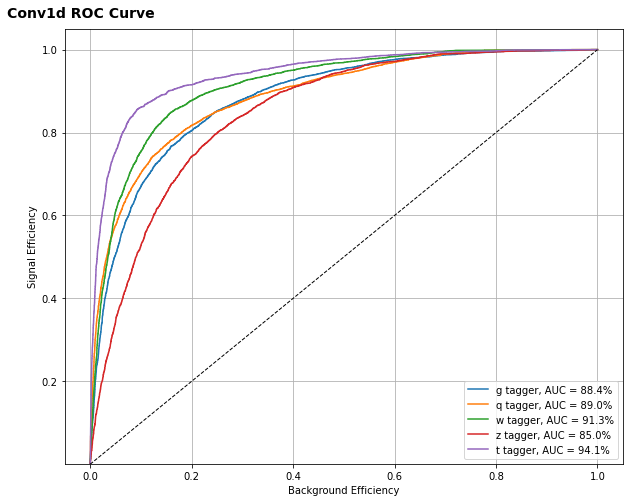

In [12]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'Conv1d ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv2d')

Text(0.25, 0.9, 'Conv_2d')

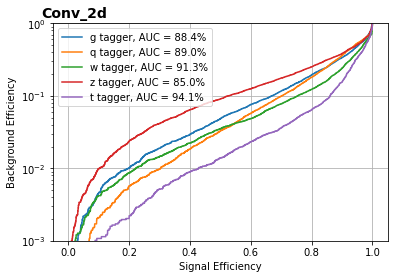

In [13]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_2d',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)


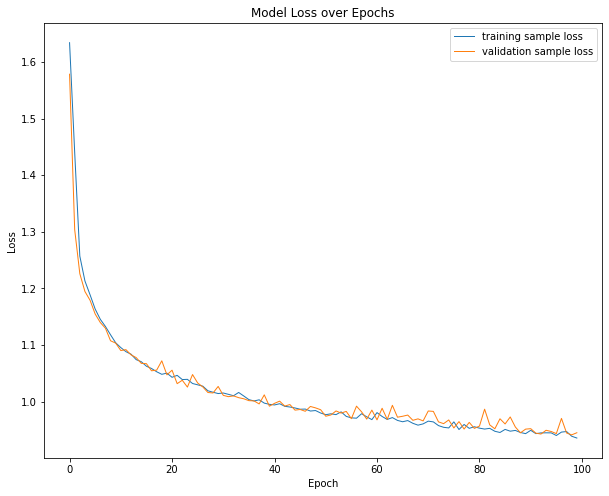

In [10]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)